<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture09/notebooks/ConvNetsTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes neuronales convolucionales (CNNs)

En la unidad anterior aprendimos cómo definir una red neuronal de múltiples capas, pero esas redes eran genéricas y no estaban especializadas en tareas de visión por computador. En esta unidad aprenderemos sobre las **Redes Neuronales Convolucionales (CNNs)**, que están diseñadas específicamente para visión por computador.

La visión por computador es diferente de la clasificación genérica, porque cuando tratamos de encontrar un cierto objeto en una imagen, estamos escaneando la imagen en busca de **patrones** específicos y sus combinaciones. Por ejemplo, al buscar un gato, podríamos primero buscar líneas horizontales, que pueden formar los bigotes, y luego cierta combinación de bigotes puede indicarnos que en realidad se trata de la imagen de un gato. La posición relativa y la presencia de ciertos patrones es importante, no su posición exacta en la imagen.

Para extraer patrones, usaremos la noción de **filtros convolucionales**. Pero primero, carguemos todas las dependencias y funciones que definimos en las unidades anteriores.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/MyDrive/Courses/AI/Lecture05'

/content/drive/MyDrive/Courses/AI/Lecture05


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tfcv import *

In this example, we will focus on the MNIST dataset that we have seen before, and on image classification. We will start by loading the dataset using Keras built-in functions.

In [5]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Filtros convolucionales

Los filtros convolucionales son pequeñas ventanas que se desplazan sobre cada píxel de la imagen y calculan un promedio ponderado de los píxeles vecinos.

Estos filtros se definen mediante matrices de coeficientes de pesos. Veamos algunos ejemplos de cómo se aplican dos filtros convolucionales diferentes sobre nuestras imágenes de dígitos manuscritos de MNIST:

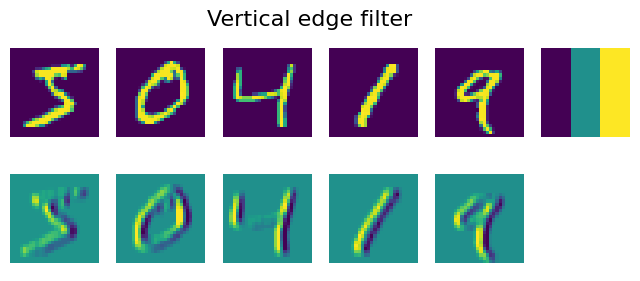

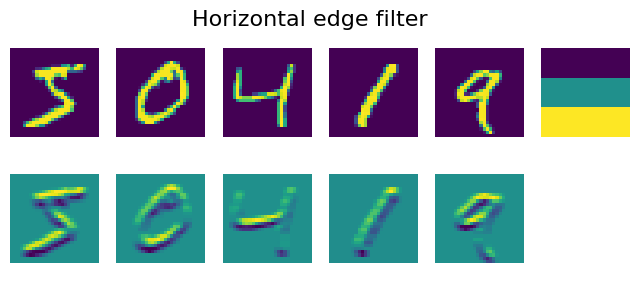

In [6]:
plot_convolution(x_train[:5],[[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]],'Vertical edge filter')
plot_convolution(x_train[:5],[[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]],'Horizontal edge filter')

El primer filtro se llama **filtro de bordes verticales**, y está definido por la siguiente matriz:

$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$

Cuando este filtro se desplaza sobre una región relativamente uniforme de píxeles, todos los valores se suman a 0. Sin embargo, cuando encuentra un borde vertical en la imagen, se genera un valor alto. Por eso, en las imágenes anteriores puedes ver que los bordes verticales están representados por valores altos y bajos, mientras que los bordes horizontales se promedian y desaparecen.

Lo contrario ocurre cuando aplicamos un filtro de bordes horizontales: las líneas horizontales se amplifican y las verticales se promedian.

En la visión por computador clásica, se aplicaban múltiples filtros a la imagen para generar características, que luego eran utilizadas por un algoritmo de aprendizaje automático para construir un clasificador. Sin embargo, en el aprendizaje profundo construimos redes que **aprenden** los mejores filtros convolucionales para resolver el problema de clasificación.

<img src="https://drive.google.com/uc?export=view&id=1HYUAPuhw3AR7kM6oyFaB-Agmp36JpXiq" />

Para lograrlo, introducimos las **capas convolucionales**.

## Capas convolucionales

Para que los pesos de una capa convolucional sean entrenables, necesitamos reducir el proceso de aplicar una ventana de filtro convolucional a una imagen a operaciones matriciales, que luego puedan ser optimizadas mediante retropropagación (*backpropagation*). Para ello, utilizamos una transformación matricial ingeniosa llamada **im2col**.

Supongamos que tenemos una imagen pequeña $\mathbf{x}$, con los siguientes píxeles:

$$
\mathbf{x} = \left(
         \begin{array}{ccccc}
           a & b & c & d & e \\
           f & g & h & i & j \\
           k & l & m & n & o \\
           p & q & r & s & t \\
           u & v & w & x & y \\
         \end{array}
     \right)
$$

Y queremos aplicar dos filtros convolucionales con los siguientes pesos:

$$
W^{(i)} = \left(\begin{array}{ccc}
            w^{(i)}_{00} & w^{(i)}_{01} & w^{(i)}_{02} \\
            w^{(i)}_{10} & w^{(i)}_{11} & w^{(i)}_{12} \\
            w^{(i)}_{20} & w^{(i)}_{21} & w^{(i)}_{22} \\
            \end{array}\right)
$$

Al aplicar la convolución, el primer píxel del resultado se obtiene por la multiplicación elemento a elemento de:

$$
\left(\begin{array}{ccc}
  a & b & c \\
  f & g & h \\
  k & l & m \\
\end{array}\right)
\quad \text{y} \quad W^{(i)}
$$

El segundo valor se calcula con:

$$
\left(\begin{array}{ccc}
  b & c & d \\
  g & h & i \\
  l & m & n \\
\end{array}\right)
\times W^{(i)}
$$

y así sucesivamente.

Para formalizar este proceso, extraemos todos los fragmentos $3\times3$ de la imagen original $x$ en la siguiente matriz:

$$
\mathrm{im2col}(x) = \left[
        \begin{array}{cccccc}
          a & b & \ldots & g & \ldots & m \\
          b & c & \ldots & h & \ldots & n \\
          c & d & \ldots & i & \ldots & o \\
          f & g & \ldots & l & \ldots & r \\
          g & h & \ldots & m & \ldots & s \\
          h & i & \ldots & n & \ldots & t \\
          k & l & \ldots & q & \ldots & w \\
          l & m & \ldots & r & \ldots & x \\
          m & n & \ldots & s & \ldots & y \\
        \end{array}
    \right]
$$

Cada columna de esta matriz corresponde a una subregión $3\times3$ de la imagen original.

Ahora, para obtener el resultado de la convolución, simplemente multiplicamos esta matriz por la matriz de pesos:

$$
\mathbf{W} = \left[
         \begin{array}{cccccccc}
            w^{(0)}_{00} & w^{(0)}_{01} & w^{(0)}_{02} & w^{(0)}_{10} & w^{(0)}_{11} & \ldots & w^{(0)}_{21} & w^{(0)}_{22} \\
            w^{(1)}_{00} & w^{(1)}_{01} & w^{(1)}_{02} & w^{(1)}_{10} & w^{(1)}_{11} & \ldots & w^{(1)}_{21} & w^{(1)}_{22} \\
         \end{array}
       \right]
$$

(cada fila de esta matriz contiene los pesos del filtro $i$, aplanados en una sola fila)

Así, la aplicación de un filtro convolucional a la imagen original se puede reemplazar por una multiplicación matricial, operación que ya sabemos cómo manejar usando retropropagación:

$$
C(x) = W\times\mathbf{im2col}(x)
$$

---

Las capas convolucionales en PyTorch se definen usando la clase `Conv2d`. Necesitamos especificar lo siguiente:

* `filters` – número de filtros a utilizar. Usaremos 9 filtros diferentes, lo que le dará a la red muchas oportunidades para explorar qué filtros funcionan mejor para nuestro caso.
* `kernel_size` – tamaño de la ventana deslizante. Usualmente se usan filtros de 3x3 o 5x5.

Una CNN sencilla contiene solo una capa convolucional. Dado un tamaño de entrada de 28x28, al aplicar nueve filtros de 5x5 obtenemos un tensor de tamaño 24x24x9. La dimensión espacial es más pequeña porque solo hay 24 posiciones donde una ventana de longitud 5 puede encajar en 28 píxeles.

Después de la convolución, aplanamos el tensor de 24x24x9 en un solo vector de tamaño 5184, y luego agregamos una capa lineal para producir 10 clases. También usamos la función de activación `relu` entre capas.

In [11]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=9, kernel_size=(5,5), activation='relu')(inputs)
x = layers.Flatten()(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['acc'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 9)           │             234 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          51,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,084 (203.45 KB)

 Trainable params: 52,084 (203.45 KB)

 Non-trainable params: 0 (0.00 B)

You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. This allows us to achieve good results even on smaller datasets, because convolutional networks generalize much better.

> **Note**: In most of the practical cases, we want to apply convolutional layers to color images. Thus, `Conv2D` layer expects the input to be of the shape $W\times H\times C$, where $W$ and $H$ are width and height of the image, and $C$ is the number of color channels. For grayscale images, we need the same shape with $C=1$.

We need to reshape our data before starting training:

In [12]:
x_train_c = np.expand_dims(x_train,3)
x_test_c = np.expand_dims(x_test,3)
hist = model.fit(x_train_c,y_train,validation_data=(x_test_c,y_test),epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - acc: 0.9016 - loss: 0.3475 - val_acc: 0.9704 - val_loss: 0.0943
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - acc: 0.9760 - loss: 0.0830 - val_acc: 0.9805 - val_loss: 0.0619
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - acc: 0.9824 - loss: 0.0617 - val_acc: 0.9821 - val_loss: 0.0555
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - acc: 0.9848 - loss: 0.0512 - val_acc: 0.9838 - val_loss: 0.0476
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - acc: 0.9869 - loss: 0.0468 - val_acc: 0.9840 - val_loss: 0.0472


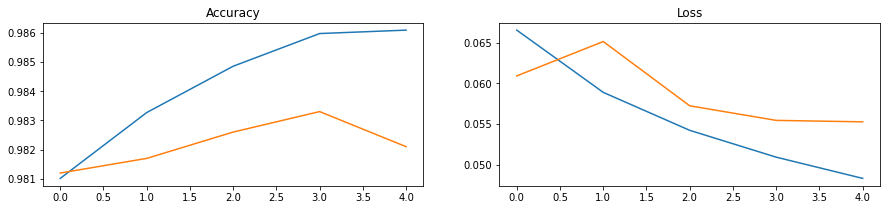

In [ ]:
plot_results(hist)

Como puedes ver, logramos una mayor precisión y mucho más rápido (en términos de número de épocas), en comparación con las redes completamente conectadas vistas en la unidad anterior. Sin embargo, el entrenamiento en sí requiere más recursos y puede ser más lento en computadores sin GPU.

---

## Visualización de capas convolucionales

También podemos visualizar los pesos de nuestras capas convolucionales entrenadas para tratar de entender un poco mejor qué está ocurriendo:


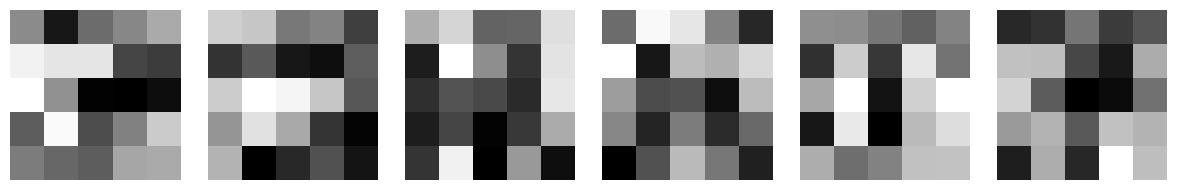

In [22]:
# Get the weights of the first Conv2D layer
kernels = model.layers[0].get_weights()[0]  # shape: (5, 5, 1, 10)

fig, ax = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    ax[i].imshow(kernels[:, :, 0, i], cmap='gray')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Podemos observar que algunos de esos filtros parecen capaces de reconocer trazos oblicuos, mientras que otros parecen bastante aleatorios.

> **Tarea**: Entrena la misma red con filtros de 3x3 y visualízalos. ¿Ves patrones más familiares?

---

## CNNs multicapa y capas de agrupamiento (*pooling*)

Las primeras capas convolucionales detectan patrones primitivos, como líneas horizontales o verticales, pero podemos aplicar capas convolucionales adicionales sobre ellas para detectar patrones de nivel superior, como formas básicas. Luego, más capas pueden combinar esas formas en partes más complejas de la imagen, hasta llegar al objeto final que queremos clasificar.

Al hacerlo, podemos aplicar una técnica adicional: reducir el tamaño espacial de la imagen. Una vez hemos detectado que existe un trazo horizontal dentro de una ventana deslizante de 3x3, no es tan importante saber en qué píxel exacto ocurrió. Por tanto, podemos **reducir la escala** de la imagen, lo cual se realiza mediante una de las siguientes **capas de agrupamiento (pooling)**:

* **Agrupamiento promedio (Average Pooling)**: toma una ventana deslizante (por ejemplo, de 2x2 píxeles) y calcula el promedio de los valores dentro de esa ventana.
* **Agrupamiento máximo (Max Pooling)**: reemplaza la ventana por el valor máximo. La idea detrás del *max pooling* es detectar la presencia de un patrón específico dentro de la ventana deslizante.

Por lo tanto, en una CNN típica se utilizan varias capas convolucionales, intercaladas con capas de agrupamiento que reducen las dimensiones espaciales de la imagen. También aumentamos el número de filtros, ya que a medida que los patrones se vuelven más complejos, hay más combinaciones posibles interesantes que queremos detectar.

<img src="https://drive.google.com/uc?export=view&id=1XjDnU_qpb4AuEwiC0RPg-jw6J_GC8NrU" />

Debido a la disminución progresiva de las dimensiones espaciales y al aumento en el número de características/filtros, esta arquitectura también se conoce como **arquitectura piramidal**.


In [14]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=(5,5), input_shape=(28,28,1), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(filters=20, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 10)          │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 20)            │           5,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           3,210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,490 (33.16 KB)

 Trainable params: 8,490 (33.16 KB)

 Non-trainable params: 0 (0.00 B)

Nota que el número de parámetros entrenables (~8.5K) es dramáticamente menor que en los casos anteriores. Esto ocurre porque las capas convolucionales, en general, tienen pocos parámetros, y la dimensionalidad de la imagen antes de aplicar la capa densa final se reduce significativamente.

Un número reducido de parámetros tiene un impacto positivo en nuestros modelos, ya que ayuda a prevenir el *overfitting*, incluso cuando trabajamos con conjuntos de datos pequeños.


In [15]:
hist = model.fit(x_train_c,y_train,validation_data=(x_test_c,y_test),epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - acc: 0.8727 - loss: 0.4400 - val_acc: 0.9754 - val_loss: 0.0781
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - acc: 0.9751 - loss: 0.0870 - val_acc: 0.9826 - val_loss: 0.0521
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - acc: 0.9814 - loss: 0.0611 - val_acc: 0.9868 - val_loss: 0.0398
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - acc: 0.9856 - loss: 0.0487 - val_acc: 0.9870 - val_loss: 0.0360
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - acc: 0.9882 - loss: 0.0391 - val_acc: 0.9888 - val_loss: 0.0330


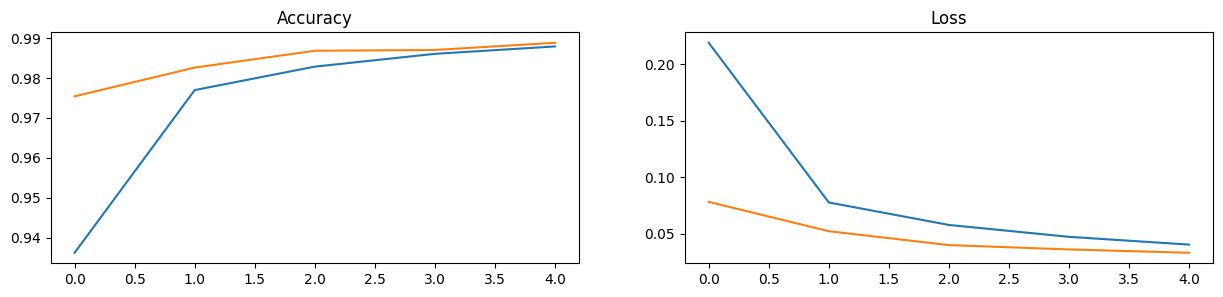

In [16]:
plot_results(hist)

Lo que probablemente deberías notar es que logramos una mayor precisión que con solo una capa, y mucho más rápido en términos de número de épocas —con apenas 1 o 2 épocas. Esto significa que una arquitectura de red sofisticada necesita muchos menos datos para entender qué está ocurriendo y para extraer patrones genéricos de nuestras imágenes.

Sin embargo, el entrenamiento también toma más tiempo y requiere una GPU.

---

## Trabajando con imágenes reales del conjunto de datos CIFAR-10

Aunque nuestro problema de reconocimiento de dígitos manuscritos puede parecer un problema de juguete, ahora estamos listos para hacer algo más serio. Vamos a explorar un conjunto de datos más avanzado con imágenes de diferentes objetos, llamado [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto contiene 60,000 imágenes de tamaño 32x32, divididas en 10 clases.
ided into 10 classes.

In [17]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


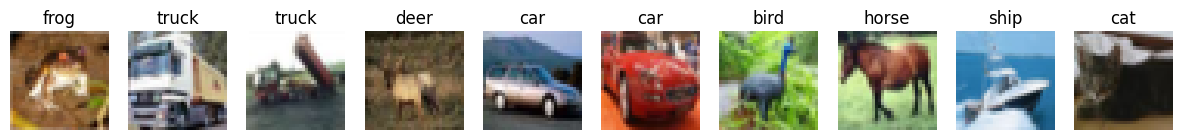

In [18]:
display_dataset(x_train,y_train,classes=classes)

Una arquitectura bien conocida para CIFAR-10 se llama [LeNet](https://es.wikipedia.org/wiki/LeNet), y fue propuesta por *Yann LeCun*. Esta sigue los mismos principios que hemos descrito anteriormente, con la principal diferencia de que utiliza 3 canales de entrada (color) en lugar de 1 (escala de grises).

In [19]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,3)),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation = 'relu'),
    keras.layers.Dense(84, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,006 (242.21 KB)

 Trainable params: 62,006 (242.21 KB)

 Non-trainable params: 0 (0.00 B)

Training this network properly will take significant amount of time, and should preferably be done on GPU-enabled compute.

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6205 - acc: 0.4033 - val_loss: 1.4287 - val_acc: 0.4743
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3435 - acc: 0.5154 - val_loss: 1.2804 - val_acc: 0.5412
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.2225 - acc: 0.5645 - val_loss: 1.2164 - val_acc: 0.5600
Epoch 4/10
1563/1563 [==============================] - 5s 4ms/step - loss: 1.1360 - acc: 0.5957 - val_loss: 1.1918 - val_acc: 0.5768
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0776 - acc: 0.6178 - val_loss: 1.1451 - val_acc: 0.5906
Epoch 6/10
1563/1563 [==============================] - 5s 4ms/step - loss: 1.0228 - acc: 0.6370 - val_loss: 1.1178 - val_acc: 0.6098
Epoch 7/10
1563/1563 [==============================] - 5s 4ms/step - loss: 0.9769 - acc: 0.6544 - val_loss: 1.0793 - val_acc: 0.6202
Epoch 8/10
1563/1563 [==============================] - 5s 3ms

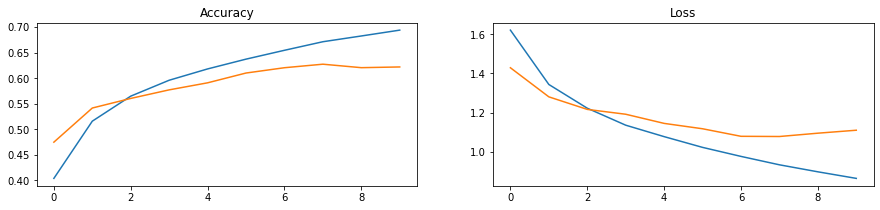

In [ ]:
plot_results(hist)

La precisión que hemos logrado con solo 3 épocas de entrenamiento no parece muy alta. Sin embargo, recuerda que una predicción al azar nos daría apenas un 10% de precisión, y que nuestro problema es considerablemente más difícil que la clasificación de dígitos en MNIST. Obtener más del 50% de precisión en tan poco tiempo de entrenamiento es un buen logro.

---

## Conclusiones

En esta unidad, hemos aprendido el concepto principal detrás de las redes neuronales para visión por computador: las redes convolucionales. Las arquitecturas reales que impulsan la clasificación de imágenes, la detección de objetos e incluso la generación de imágenes están todas basadas en CNNs, solo que con más capas y algunos trucos adicionales de entrenamiento.